In [1]:
from tcn import TCN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
data=pd.read_csv('T2.csv')

In [3]:
data.drop('time', inplace=True, axis=1)

In [4]:
data

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,380.047791,5.311336,416.328908,259.994904
1,453.769196,5.672167,519.917511,268.641113
2,306.376587,5.216037,390.900016,272.564789
3,419.645904,5.659674,516.127569,271.258087
4,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
52555,2963.980957,11.404030,3397.190793,80.502724
52556,1684.353027,7.332648,1173.055771,84.062599
52557,2201.106934,8.435358,1788.284755,84.742500
52558,2515.694092,9.421366,2418.382503,84.297913


In [5]:
df=data['LV ActivePower (kW)']

In [6]:
for i in range(0, len(df)):
  if df[i] <= 0:
    print('negative at ==',i)
    i
  

negative at == 608
negative at == 933
negative at == 2114
negative at == 3037
negative at == 4424
negative at == 5134
negative at == 6062
negative at == 6093
negative at == 6105
negative at == 6114
negative at == 6221
negative at == 6905
negative at == 6910
negative at == 6969
negative at == 7308
negative at == 7309
negative at == 7323
negative at == 7331
negative at == 7342
negative at == 7358
negative at == 7433
negative at == 7577
negative at == 8442
negative at == 8592
negative at == 9021
negative at == 10081
negative at == 10083
negative at == 13391
negative at == 13395
negative at == 18440
negative at == 21839
negative at == 21949
negative at == 22991
negative at == 23924
negative at == 24056
negative at == 27788
negative at == 28091
negative at == 29140
negative at == 29666
negative at == 29813
negative at == 29928
negative at == 30067
negative at == 30068
negative at == 30069
negative at == 30070
negative at == 30071
negative at == 30072
negative at == 30992
negative at == 3524

In [7]:
num_train_samples=int(0.5 *len(data))
num_val_samples=int(0.25* len(data))
num_test_samples= len(data)-num_train_samples-num_val_samples

In [8]:
#Normalization of data
mean=data.mean(axis=0)
data -= mean

In [9]:
std =data.std(axis=0)
data /= std

In [10]:
data

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,-0.746271,-0.534809,-0.814109,1.480642
1,-0.688842,-0.448718,-0.737507,1.573494
2,-0.803662,-0.557546,-0.832913,1.615630
3,-0.715424,-0.451699,-0.740310,1.601597
4,-0.745802,-0.471199,-0.758371,1.541633
...,...,...,...,...
52555,1.266630,0.918847,1.390174,-0.446921
52556,0.269791,-0.052544,-0.254526,-0.408691
52557,0.672346,0.210552,0.200423,-0.401390
52558,0.917412,0.445803,0.666367,-0.406164


In [11]:
raw_data=data
target=data['LV ActivePower (kW)']

In [13]:
target

0       -0.746271
1       -0.688842
2       -0.803662
3       -0.715424
4       -0.745802
           ...   
52555    1.266630
52556    0.269791
52557    0.672346
52558    0.917412
52559    1.154831
Name: LV ActivePower (kW), Length: 52560, dtype: float64

In [21]:
sampling_rate = 6 # har 6th sample ko include karo 0-5 tak ignore 6th becomes first
sequence_length = 120 # 5 days ka data le raha hai 
delay = 6*(sequence_length + 24 - 1) # 24, 36 and 72 hours prior rakhna hai according to paper
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[0:num_train_samples],
 targets=target[delay:num_train_samples],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=False,
 batch_size=batch_size,)
 #start_index=0,
 #end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[num_train_samples+1:num_train_samples+num_val_samples],
 targets=target[delay:num_train_samples+num_val_samples],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=False,
 batch_size=batch_size)
test_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[num_val_samples+num_train_samples+1:num_test_samples+num_val_samples+num_train_samples],
 targets=target[delay:num_test_samples+num_val_samples+num_train_samples],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=False,
 batch_size=batch_size)

In [22]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [23]:
for samples, targets in train_dataset:
  print('samples', samples.shape)
  print('targets', targets.shape)
  break

samples (256, 120, 4)
targets (256,)


In [24]:
from tensorflow.keras import layers

In [25]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
#48 hours prediction
model = keras.models.Sequential([
    TCN(input_shape=(120,4),#5day 4 features
        kernel_size=10,
        nb_filters=32,
        dilations=[1, 2, 4, 8,16],
        padding='causal',
        activation='relu',
        return_sequences=True,
        nb_stacks=2,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    keras.layers.Dense(1)
])

callbacks = [
keras.callbacks.ModelCheckpoint("tcn.keras",
save_best_only=True)]
model.summary()
model.compile(optimizer="adam", loss="mape",metrics=["mape"])

print('Train...')
history=model.fit(train_dataset,
                  epochs=50,
                  verbose=1,
                  batch_size=256,
                  validation_data=val_dataset,
                  callbacks=callbacks)
p =model.predict(samples)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_1 (TCN)                 (None, 120, 32)           196640    
                                                                 
 dense_1 (Dense)             (None, 120, 1)            33        
                                                                 
Total params: 196,673
Trainable params: 196,673
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/50
100/100 [==============================] - 202s 2s/step - loss: 764.7419 - mape: 764.7417 - val_loss: 229.4052 - val_mape: 229.4052
Epoch 2/50
100/100 [==============================] - 193s 2s/step - loss: 284.0549 - mape: 284.0548 - val_loss: 178.3540 - val_mape: 178.3540
Epoch 3/50
100/100 [==============================] - 186s 2s/step - loss: 265.4981 - mape: 265.4980 - val_loss: 181.7788 - val_mape: 181.7788
Epoch 

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mape"]
val_loss = history.history["val_mape"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAPE")
plt.plot(epochs, val_loss, "b", label="Validation MAPE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [331]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [341]:
#72 hours prediction
model = keras.models.Sequential([
    TCN(input_shape=(120,4),#5 day 4 features
        kernel_size=10,
        nb_filters=32,
        dilations=[1, 2, 4, 8,16],
        padding='causal',
        activation='relu',
        return_sequences=True,
        nb_stacks=2,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    keras.layers.Dense(1)
])
model.summary()
model.compile(optimizer= 'adam', loss= 'mape', metrics=['mape'])

print('Train...')
history = model.fit(train_dataset,
                    epochs=50,
                    verbose=2,
                    batch_size=256,
                    validation_data=val_dataset,
                    callbacks=callbacks
)
p=model.predict(samples)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_10 (TCN)                (None, 120, 32)           196640    
                                                                 
 dense_29 (Dense)            (None, 120, 1)            33        
                                                                 
Total params: 196,673
Trainable params: 196,673
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
100/100 - 204s - loss: 1050.7867 - mape: 1050.7865 - val_loss: 386.9817 - val_mape: 386.9817 - 204s/epoch - 2s/step
Epoch 2/10
100/100 - 196s - loss: 340.9109 - mape: 340.9109 - val_loss: 236.7146 - val_mape: 236.7146 - 196s/epoch - 2s/step
Epoch 3/10
100/100 - 193s - loss: 348.0700 - mape: 348.0700 - val_loss: 270.8522 - val_mape: 270.8523 - 193s/epoch - 2s/step
Epoch 4/10
100/100 - 193s - loss: 261.5437 - mape: 261.543

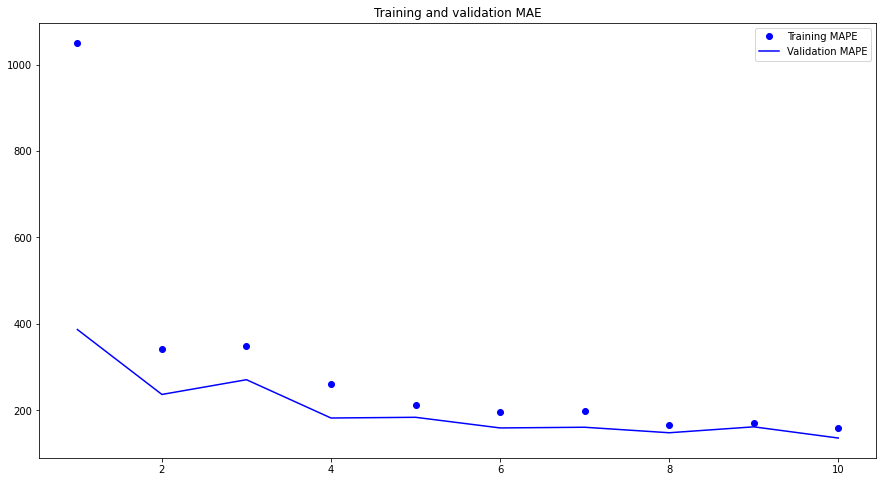

In [342]:
import matplotlib.pyplot as plt
loss = history.history["mape"]
val_loss = history.history["val_mape"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAPE")
plt.plot(epochs, val_loss, "b", label="Validation MAPE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [345]:
# 24 hours prior prediction
model = keras.models.Sequential([
    TCN(input_shape=(120,4), 
        kernel_size=10,
        nb_filters=32,
        dilations=[1, 2, 4, 8,16],
        padding='causal',
        activation='relu',
        return_sequences=True,
        nb_stacks=2,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    keras.layers.Dense(1)
])
model.summary()
model.compile(optimizer= 'adam', loss= 'mape', metrics=['mape'])

print('Train...')
history = model.fit(train_dataset,
                    epochs=10,
                    verbose=2,
                    batch_size=256,
                    validation_data=val_dataset,
                    callbacks=callbacks
)

p = model.predict(samples)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_11 (TCN)                (None, 120, 32)           196640    
                                                                 
 dense_30 (Dense)            (None, 120, 1)            33        
                                                                 
Total params: 196,673
Trainable params: 196,673
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
103/103 - 203s - loss: 719.8321 - mape: 719.8324 - val_loss: 290.7337 - val_mape: 290.7338 - 203s/epoch - 2s/step
Epoch 2/10
103/103 - 200s - loss: 336.6355 - mape: 336.6355 - val_loss: 267.2080 - val_mape: 267.2080 - 200s/epoch - 2s/step
Epoch 3/10
103/103 - 200s - loss: 203.4320 - mape: 203.4320 - val_loss: 156.2625 - val_mape: 156.2625 - 200s/epoch - 2s/step
Epoch 4/10
103/103 - 200s - loss: 167.3701 - mape: 167.3701

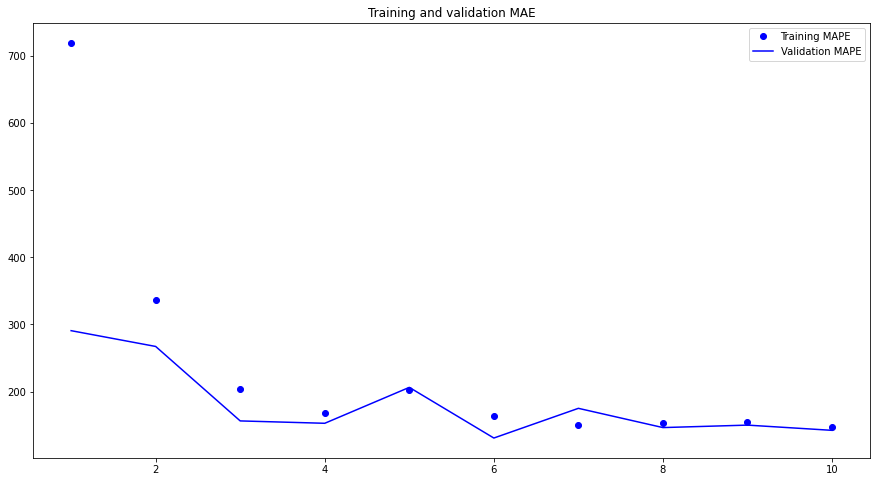

In [346]:
import matplotlib.pyplot as plt
loss = history.history["mape"]
val_loss = history.history["val_mape"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAPE")
plt.plot(epochs, val_loss, "b", label="Validation MAPE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()